# Prediction Model for EdX Dataset 

## Import the Libraries / modules 

In [3]:
import numpy as np 
import pandas as pd 
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sb
import warnings

In [4]:
#------ PATH to data file
file='HMXPC13_DI_v2_5-14-14.csv'
path='data'
filename=path+'/'+file

In [5]:
#-----  READ THE CSV to data frame 
full_df = pd.read_csv(filename,parse_dates=True)

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Extract the data fields 
* Impute the missing info
* clean up for processing 

In [6]:

# Extract relevant fields 
data = full_df[['course_id','userid_DI','final_cc_cname_DI','LoE_DI','YoB','gender','start_time_DI','grade','viewed','explored','nevents','ndays_act','nplay_video','nchapters','certified','registered','incomplete_flag']].copy()

#---- from course_id get the institution / course / year / term details 
a,b,c = data['course_id'].str.split('/').str
data.insert(1,'institution',a)
data.insert(2,'course',b)
a = c.str.split('_').str[0]
b = c.str.split('_').str[1]
data.insert(3,'year',a)
data.insert(4,'term',b)
data.drop('course_id',axis=1,inplace=True)

#-----  Create the mapping of course-id to text title 
courselist = {'CB22x':'Greek Heros', 'CS50x':'Computer Science','ER22x':'Justice','PH207x':'Health Stat','PH278x':'Health Env','14.73x':'Poverty','2.01x':'Structures','3.091x':'SS Chemistry','6.002x':'Circuits','6.00x':'Computer Pgming','7.00x':'Biology','8.02x':'Electricity & Magnetism','8.MReV':'Mechanics'}
data['course'].replace(courselist, inplace=True)

#------- rename columns 
data.rename(columns={'nchapters':'chapters viewed','ndays_act':'days active','nplay_video':'videos played','course_id': 'course', 'final_cc_cname_DI': 'country','LoE_DI':'education','userid_DI':'user',"start_time_DI":"start-time"}, inplace=True)

#-------- Fill the gaps in user data 

data['YoB'] = data.groupby('course')['YoB'].transform(lambda x: x.fillna(x.median()))
data['gender'] = data.groupby('course')['gender'].transform(lambda x: x.fillna(x.value_counts().index[0]))
data['education'] = data.groupby('course')['education'].transform(lambda x: x.fillna(x.value_counts().index[0]))



## Clean up / format the data 

In [7]:

#-------------- change the datatypes of some of the columns
data['institution']= data.institution.astype('category')
data['course']= data.course.astype('category')

e_order = ["Less than Secondary","Secondary","Bachelor's","Master's","Doctorate"]
data['grade'] = pd.to_numeric(data['grade'],errors='coerce')
data['grade'] = data['grade'].fillna(0).multiply(100)
data['education']= data.education.astype('category').cat.set_categories(e_order, ordered=True)

#-------Replace NaN data with zeros
data['chapters viewed'].fillna(0,inplace=True) # replace NaN with 0 
data['nevents'].fillna(0,inplace=True) # replace NaN with 0 
data['videos played'].fillna(0,inplace=True) # replace NaN with 0 
data['chapters viewed'].fillna(0,inplace=True) # replace NaN with 0 
data['days active'].fillna(0,inplace=True) # replace NaN with 0 
data['term'].fillna('Fall',inplace=True)

data['gender']= data.gender.astype('category')
data['year']= data.year.astype('int')
data['YoB']= data.YoB.astype('int')
data['nevents']= data.nevents.astype('int')

#-------- set the date-time type 
data['start-time'] = pd.to_datetime(data['start-time'])

#-------- Add a column "age" using YoB (age calculated as on 2014)
data.insert(3,"age", [(x.year-x.YoB) for index, x in data.iterrows() ])

## Encode the categorical/text fields for model building 

In [8]:

modeldata = data.copy()

#---------- Encode the categorical/text fields for building the model
encoder = LabelEncoder()
icode = encoder.fit_transform(data['institution'])
ccode = encoder.fit_transform(data['country'])
cscode = encoder.fit_transform(data['course'])
educode = encoder.fit_transform(data['education'])
gendercode=encoder.fit_transform(data['gender'])
usercode=encoder.fit_transform(data['user'])

# Eliminate the categorical data and use the encoded information 
modeldata.drop(['institution','term','start-time','course','country','education','YoB','year','gender','registered','user','incomplete_flag'],axis=1,inplace=True)

#modeldata.insert(0,"user",usercode)
modeldata.insert(1,"country",ccode)
modeldata.insert(2,"course",cscode)
modeldata.insert(3,"education",educode)
modeldata.insert(4,"gender",gendercode)
modeldata.insert(5,"institution",icode)

modeldata.fillna(0,inplace=True) # replace NaN with 0 


In [9]:
modeldata = modeldata[modeldata.age >= 10] #Use only valid entries 
#-----------we treat only registrants who have viewed the content as valid data for model building

vdata = modeldata[modeldata.viewed==1] # full dataset with all variables - demohraphics + administrative 
vdata_adm = vdata.copy()               # dataset with  administrative variables
vdata_dem = vdata.copy()               # dataset with  demographic variables

vdata.drop(['viewed','grade'],axis=1,inplace=True)
vdata_dem.drop(['viewed','grade','nevents','days active','videos played','chapters viewed'],axis=1,inplace=True)
vdata_adm.drop(['viewed','grade','country','education','gender','age'],axis=1,inplace=True)



/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
col1 = ["0 (Actual)","1 (Actual)"]
col2 = ["0 (Pred)","1 (Pred)"]

In [11]:
def split_dataset(dataset, test_percent):
    """
    Split the dataset with test_percent
    :param dataset:
    :param train_percentage:
    :return: train_x, test_x, train_y, test_y
    """
 
    # Split dataset into train and test dataset
    X = dataset.drop(['certified'],axis = 1)
    Y = dataset['certified']
    train_x, test_x, train_y, test_y = train_test_split(X,Y,test_size = test_percent,random_state=42)
                                                        
    return train_x, test_x, train_y, test_y

def logreg_classifier(features, target,test):
    """
    :param features:
    :param target:
    :return: trained Logistic Regression classifier
    """
    clf = LogisticRegression()
    clf.fit(features, target)
    return clf.predict(test)


## Logistic Regression Model
* 1) Using only the demographics (user data such as age,gender,educational background etc)
* 2) Using the administrative information (such as the course interaction details )
* 3) Using both demographics and adminstrative information 

In [12]:
#----  Logistic Regression Model 1 - Using the demographics 
X_dem_train, X_dem_test, y_dem_train, y_dem_test = split_dataset(vdata_dem,0.5)
y_dem_pred = logreg_classifier(X_dem_train, y_dem_train,X_dem_test)
print("Classification Report of Model Using only Demographics")
print("-------------------------------------------------------------")
print(classification_report(y_dem_test, y_dem_pred))

#---- Logistic Regression Model 2 - Using the administrative info
X_adm_train, X_adm_test, y_adm_train, y_adm_test = split_dataset(vdata_adm,0.5)
y_adm_pred = logreg_classifier(X_adm_train, y_adm_train,X_adm_test)
print("Classification Report of Model Using only Administrative Info")
print("-------------------------------------------------------------")
print(classification_report(y_adm_test, y_adm_pred))

#---- Logistic Regression Model 3 - Using both demographics+ administrative info
X_train, X_test, y_train, y_test = split_dataset(vdata,0.5)
y_pred = logreg_classifier(X_train, y_train,X_test)
print("Classification Report of Model Using both Demographics, Administrative Info")
print("-------------------------------------------------------------")
print(classification_report(y_test, y_pred))

Classification Report of Model Using only Demographics
-------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.97      0.99      0.98    191094
          1       0.62      0.28      0.38      8855

avg / total       0.95      0.96      0.95    199949

Classification Report of Model Using only Administrative Info
-------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    191094
          1       0.78      0.70      0.74      8855

avg / total       0.98      0.98      0.98    199949

Classification Report of Model Using both Demographics, Administrative Info
-------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    191094
          1       0.78      0.71      0.74      8855

avg / total       0.98      0.

## Evaluation Metrics for the Logistic Regression Models

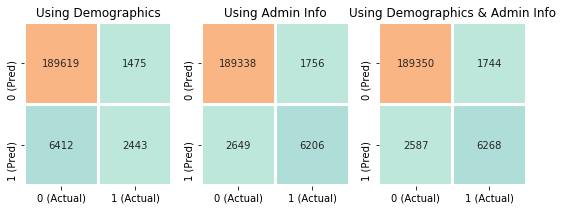

In [13]:
%matplotlib inline
cm1 = confusion_matrix(y_dem_test, y_dem_pred)
cm2 = confusion_matrix(y_adm_test, y_adm_pred)
cm3 = confusion_matrix(y_test, y_pred)
fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].set_title("Using Demographics")
axs[1].set_title("Using Admin Info")
axs[2].set_title("Using Demographics & Admin Info")
sb.heatmap(pd.DataFrame(cm1, columns=col1, index=col2),annot=True,fmt="d", linewidths=2,cbar=False,center=100000,ax=axs[0]);
sb.heatmap(pd.DataFrame(cm2, columns=col1, index=col2),annot=True,fmt="d", linewidths=2,cbar=False,center=100000,ax=axs[1]);
sb.heatmap(pd.DataFrame(cm3, columns=col1, index=col2),annot=True,fmt="d", linewidths=2,cbar=False,center=100000,ax=axs[2]);

### The logistic ression model using both demographics+administrative fields gives a better performance ( higher precision , recall and f1 score)

## Here we tune the hyper parameters to get the best model 

In [14]:
start_time = time.time()

#-------  Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

#------   Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5,refit=True)

#-------  Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))
print("run time %s seconds " % (time.time() - start_time))
#-----------   Predict the results on test data  
y_pred_tn = logreg_cv.predict(X_test)

Tuned Logistic Regression Parameter: {'penalty': 'l2', 'C': 3.7275937203149381}
Tuned Logistic Regression Accuracy: 0.9783993838397983
run time 351.91000604629517 seconds 


## Lets look at the performance metrics for the tuned logistic regression model

''

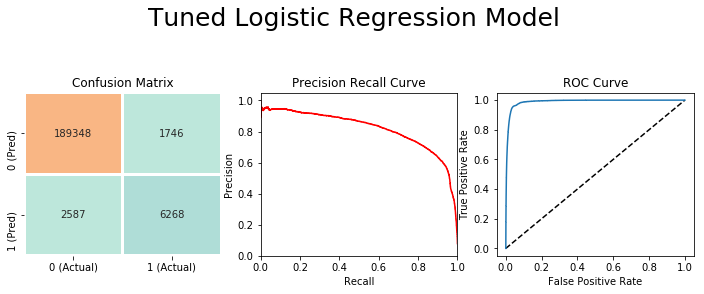

In [15]:
%matplotlib inline
fig, axs = plt.subplots(1,3,figsize=(12,3))

sb.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_tn), columns=col1, index=col2),annot=True,fmt="d", linewidths=2,center=100000,cbar=False,ax=axs[0]);

y_pred_p = logreg_cv.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_p)
axs[1].plot(recall, precision, color='r');


axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])


# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_p)

# Plot ROC curve
axs[2].plot([0, 1], [0, 1], 'k--');
axs[2].plot(fpr, tpr);
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')


axs[0].set_title('Confusion Matrix')
axs[1].set_title('Precision Recall Curve')
axs[2].set_title('ROC Curve')
plt.text(-2, 1.5, "Tuned Logistic Regression Model", fontsize=25)
;




## Feature Extraction 

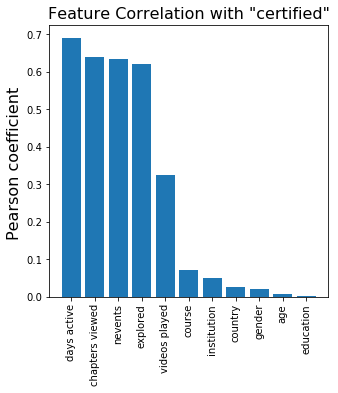

In [16]:
def display_corr(dataset, target):
    corr_matrix = dataset.corr()
    corr = corr_matrix[target].copy()
    abs_corr = corr.apply(lambda x: abs(x))
    
    sorted_values = abs_corr.sort_values(ascending=False)
    y_val = list(sorted_values.values)[1:]
    x_val = range(0,len(y_val))
    
    xlabels = list(sorted_values.keys())[1:]
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.bar(x_val, y_val)
    ax.set_title('Feature Correlation with "{}"'.format(target), fontsize=16)
    ax.set_ylabel('Pearson coefficient ', fontsize=16)
    plt.xticks(x_val, xlabels, rotation='vertical')
    plt.show()
 
display_corr(vdata, 'certified')

## Lets try Random Forest for building the model

In [17]:
start_time = time.time()

RandForest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

RandForest.fit(X_train,y_train)

y_pred_f = RandForest.predict(X_test)
y_pred_pf = RandForest.predict_proba(X_test)[:,1]

print("Classification Report of Random Forest Classifier            ")
print("-------------------------------------------------------------")
print(classification_report(y_test, y_pred_f))
print("run time %s seconds " % (int(time.time() - start_time)))


Classification Report of Random Forest Classifier            
-------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    191094
          1       0.83      0.78      0.81      8855

avg / total       0.98      0.98      0.98    199949

run time 2 seconds 


## Lets look at the performance metrics for the Random Forest Classifier

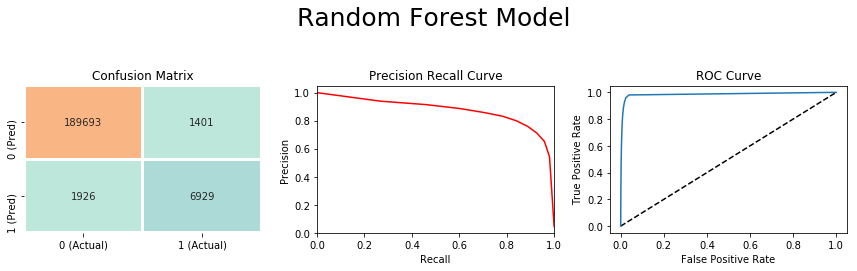

In [18]:
%matplotlib inline

fig, axs = plt.subplots(1,3,figsize=(12,3))

plt.text(-1.5, 1.5, "Random Forest Model", fontsize=25)
sb.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_f), columns=col1, index=col2),annot=True,fmt="d", linewidths=2,center=100000,cbar=False,ax=axs[0]);


precision, recall, _ = precision_recall_curve(y_test, y_pred_pf)
axs[1].plot(recall, precision, color='r');


axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])


# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_pf)

# Plot ROC curve
axs[2].plot([0, 1], [0, 1], 'k--');
axs[2].plot(fpr, tpr);
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')


axs[0].set_title('Confusion Matrix')
axs[1].set_title('Precision Recall Curve')
axs[2].set_title('ROC Curve')
;
fig.tight_layout()

## Performance for the Random Forest is better than the logistic regression

## Addressing class imbalance with SMOTE (Minority class oversampling )

In [19]:
sm = SMOTE(random_state=42, ratio = 0.3)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print("Class size 0(not certified) and 1(certified) of original training set")
print(np.bincount(y_train))

print("\nClass size 0(not certified) and 1(certified) of upsampled(SMOTE) training set")
print(np.bincount(y_train_res))

Class size 0(not certified) and 1(certified) of original training set
[191116   8832]

Class size 0(not certified) and 1(certified) of upsampled(SMOTE) training set
[191116  57334]


In [20]:

# LogReg on SMOTE upsampled set 
logreg_cv.fit(X_train_res, y_train_res)
y_pred_res = logreg_cv.predict(X_test)
y_pred_rl = logreg_cv.predict_proba(X_test)[:,1]

# ForestReg = RandomForestRegressor()
RandForest.fit(X_train_res,y_train_res)
y_pred_res_f = RandForest.predict(X_test)
y_pred_rf = RandForest.predict_proba(X_test)[:,1]

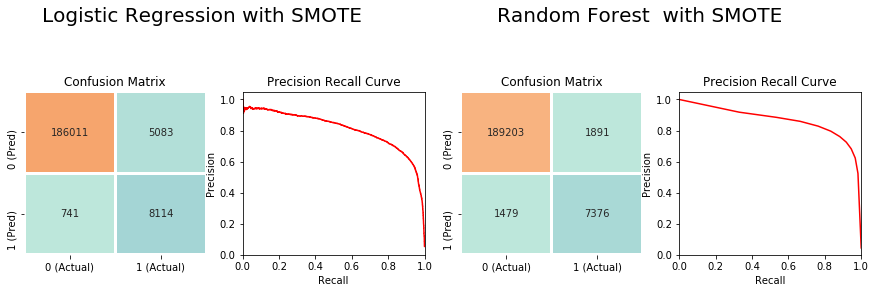

In [21]:
%matplotlib inline

fig, axs = plt.subplots(1,4,figsize=(15,3))
sb.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_res), columns=col1, index=col2),annot=True,fmt="d", linewidths=2,center=100000,cbar=False,ax=axs[0]);

precision, recall, _ = precision_recall_curve(y_test, y_pred_rl)
axs[1].plot(recall, precision, color='r');


axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlim([0.0, 1.0])

sb.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_res_f), columns=col1, index=col2),annot=True,fmt="d", linewidths=2,center=100000,cbar=False,ax=axs[2]);

precision, recall, _ = precision_recall_curve(y_test, y_pred_rf)
axs[3].plot(recall, precision, color='r');

axs[3].set_xlabel('Recall')
axs[3].set_ylabel('Precision')
axs[3].set_ylim([0.0, 1.05])
axs[3].set_xlim([0.0, 1.0])
axs[0].set_title('Confusion Matrix')
axs[1].set_title('Precision Recall Curve')
axs[2].set_title('Confusion Matrix')
axs[3].set_title('Precision Recall Curve')

plt.text(-3.5, 1.5, "Logistic Regression with SMOTE", fontsize=20)
plt.text(-1, 1.5, "Random Forest  with SMOTE", fontsize=20)



### Both True Positive and False Negative rates increase with the upsampled dataset 
### Performance of the Random Forest is better than the Logistic Regression 